In [1]:
# alpha:finish consulting; beta:new coming;
# overall timer format: (timepoint, event, station id, server id)

class Station:
    def __init__(self, stationid, overall_timer, process_param, n_server=0, n_buffer=0):
        self.stationid = stationid
        self.overall_timer = overall_timer
        self.s = n_server
        self.c = n_buffer
        self.wait = False
        self.status = [0, [0]*n_server] # 1 for occupied
        self.process_param = process_param
        self.next_station = None
    
    def setnext(self, next_station):
        self.next_station = next_station
        
    def printout(self):
        # print("time:{:.04f}".format(self.overall_timer[0][0]), " \tstation "+str(self.stationid)+":", self.status)
        return 0
    
    def update(self, timeslot):
        event= timeslot[1]
        if event == 'alpha':
            serverid = timeslot[3]
            succeed = self.alpha(serverid, timeslot)
        else:
            succeed = self.beta(timeslot)
            if not succeed:
                self.overall_timer.append((timeslot[0]+1, timeslot[1], timeslot[2]))
        del(self.overall_timer[0])
        self.overall_timer.sort(key= lambda k:(k[0], int(-k[2])))
        return succeed
        
    def alpha(self, serverid, timeslot):
        if self.next_station == None:
            if self.status[0] > 0: # wqiting line is not empty
                self.status[0] -= 1
                try:
                    self.overall_timer.append((timeslot[0]+np.random.exponential(self.process_param), 'alpha', self.stationid, serverid))
                    self.printout()
                except:
                    print("empty process time list for station", self.stationid, "server", serverid)
            else:
                self.status[1][serverid] = 0
                self.printout()
                return True
        else:
            if self.next_station.beta(timeslot):
                if self.status[0] > 0: # waiting line is not empty
                    self.status[0] -= 1
                    try:
                        self.overall_timer.append((self.overall_timer[0][0]+np.random.exponential(self.process_param), 'alpha', self.stationid, serverid))
                        # del(self.process_times[0])
                        self.printout()
                    except:
                        print("empty process time list for station", self.stationid, "server", serverid)
                else:
                    self.status[1][serverid] = 0
                    self.printout()
                    return True
            else:
                for i in range(len(self.overall_timer)):
                    if self.overall_timer[i][2]==self.stationid+1:
                        self.overall_timer.append((self.overall_timer[i][0], 'alpha', self.stationid, serverid))
                        self.overall_timer.sort(key= lambda k:(k[0], int(-k[2])))
                        return True
                self.overall_timer.append((self.overall_timer[0][0], 'alpha', self.stationid, serverid))
                self.overall_timer.sort(key= lambda k:(k[0], int(-k[2])))
            
    def beta(self, timeslot=None):
        if self.status[0] > 0: 
            if self.status[0]<self.c:
                self.status[0]+=1
                self.printout()
                return True
            else:
                return False
        else:
            i = 0
            while i < self.s:
                if self.status[1][i]==0:
                    self.status[1][i]=1
                    self.overall_timer.append((timeslot[0]+np.random.exponential(self.process_param), 'alpha', self.stationid, i))
                    # self.process_times.remove(self.process_times[0])
                    break
                else:
                    i += 1
            if i == self.s:
                self.status[0]+=1
            self.printout()
            return True
        

In [2]:
import numpy as np
class simulation_a2:
    def run(n_customers, miu):
        # print(miu)
        timer = []
        enter = 0
        t = 0
        while enter < n_customers+10:
            e = min(np.random.poisson(2.1), n_customers+10-enter)
            for i in range(e):
                timer.append((t, 'beta', 0, enter))
                enter += 1
            t += 1
            
        stations = []
        stations.append(Station(stationid=0, overall_timer=timer, process_param=miu[0], n_server=1, n_buffer=5))
        stations.append(Station(stationid=1, overall_timer=timer, process_param=miu[1], n_server=1, n_buffer=6))
        stations.append(Station(stationid=2, overall_timer=timer, process_param=miu[2], n_server=1, n_buffer=6))
        stations.append(Station(stationid=3, overall_timer=timer, process_param=miu[3], n_server=1, n_buffer=3))
        stations[2].setnext(stations[3])
        stations[1].setnext(stations[2])
        stations[0].setnext(stations[1])
        
        tt = 0
        st = 0
        while len(timer)>0:
            # print(timer)
            if timer[0][1]=='beta' and timer[0][2]==10:
                st = timer[0][0]
            tt = timer[0][0]
            stations[timer[0][2]].update(timer[0])
        return (tt-st)/n_customers
            

In [38]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

def tao(miu, n):
    j = 0
    for _ in range(n):
        j += simulation_a2.run(20, miu)/n
    return 1/j

def cost_function(miu, n):
    E = np.array([0, 2, 1, 0])
    c = tao(miu, n) + E[0]/miu[0]+E[1]/miu[1]+E[2]/miu[2]+E[3]/miu[3]
    return -c

def stochasticapproximation(miu0, m,ep, eta, power, n):
    
    miu = np.zeros((4,m))
    Delta = np.zeros(4)
    cf = np.zeros(m)
     
    miu[:,0] = miu0
    for i in range(m-1):
        if i % (m//10)==0:
            print(i*100//m, "%")
        cf[i]= cost_function(miu[:,i], n)
        
        # sample Delta vector
        a1 = np.array([-1, 1])
        Delta = np.random.choice(a=a1, size=4, replace=True, p=[0.5, 0.5])
          
        # adjust stepsize
           
        eta_step= eta/((i+1)**power) 
        
        # evaluate SPSA proxy for gradient
        
        cost_plus = cost_function(miu[:,i]+eta_step*Delta, n)
        cost_minus = cost_function(miu[:,i]-eta_step*Delta, n)
        
        # SA update and truncation
        
        for j in range(4):
            miu[j, i+1] = miu[j, i] - (ep/(i+1)**1.1)*(cost_plus - cost_minus)/(eta_step*Delta[j]) 
            miu[j, i+1] = min(max(miu[j, i+1], 0.025), 3)
        
    cf[m-1]= cost_function(miu[:,m-1], n)
    
    # ouptu: print results
    
    plt.plot(np.arange(m),miu[0,:], color='red', label='miu1')
    plt.plot(np.arange(m),miu[1,:], color='blue', label='miu2')
    plt.plot(np.arange(m),miu[2,:], color='lightgreen', label='miu3')
    plt.plot(np.arange(m),miu[3,:], color='gray', label='miu4')
    plt.legend() 
    plt.title('miu value')
    plt.show()

    plt.plot(np.arange(m),-cf)
    plt.title('negative cost function')
    plt.legend(['cost function']) 
    plt.show()


    print("Final values  theta & cost", miu[:,m-1], cost_function(miu[:,m-1], n))    
    
    return miu

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %


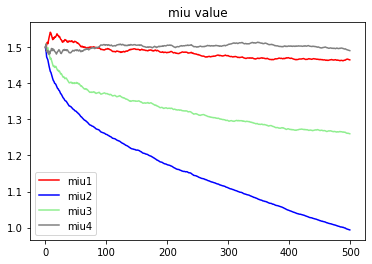

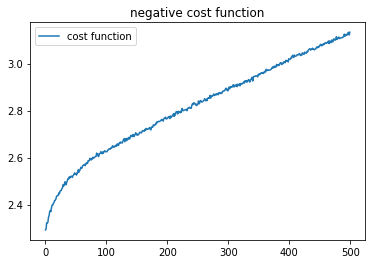

Final values  theta & cost [1.46499758 0.99352004 1.26012333 1.49061196] -3.1366569946885394


In [36]:
def main():
    
    miu0 = np.array([1.5, 1.5, 1.5, 1.5])
    
    m  = 500 # iterations
    ep = 0.01
    eta = 0.2
    power = 0.7
    n = 100
    
    miu = stochasticapproximation(miu0,m,ep,eta,power,n)
    
if __name__ == '__main__':
    main()

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %


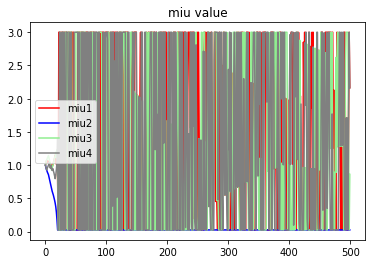

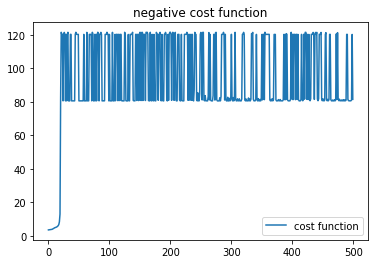

Final values  theta & cost [2.16409782 0.025      0.86090218 2.16409782] -81.40711512295013


In [37]:
def main():
    
    miu0 = np.array([1.46499758, 0.99352004, 1.26012333, 1.49061196])
    
    m  = 500 # iterations
    ep = 0.02
    eta = 0.2
    power = 0.7
    n = 100
    
    miu = stochasticapproximation(miu0,m,ep,eta,power,n)
    
if __name__ == '__main__':
    main()

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %


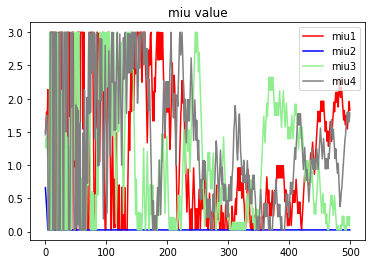

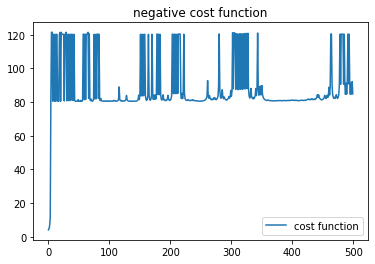

Final values  theta & cost [1.82618139 0.025      0.21704477 1.78310012] -84.90783472469128


In [40]:
def main():
    
    miu0 = np.array([1.50086917, 0.66063597, 1.2664719,  1.45773714])
    
    m  = 500 # iterations
    ep = 0.02
    eta = 0.05
    power = 0.5
    n = 100
    
    miu = stochasticapproximation(miu0,m,ep,eta,power,n)
    
if __name__ == '__main__':
    main()

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %


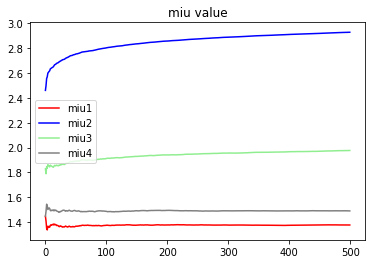

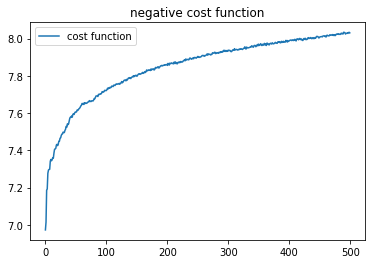

Final values  theta & cost [1.37761434 2.92741548 1.97681173 1.49089615] -8.036240719569896


In [8]:
def main():
    
    miu0 = np.array([1.44721394, 2.45999643, 1.82781249, 1.44891808])
    
    m  = 500 # iterations
    ep = 0.02
    eta = 0.2
    power = 0.5
    n = 100
    
    miu = stochasticapproximation(miu0,m,ep,eta,power,n)
    
if __name__ == '__main__':
    main()

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %


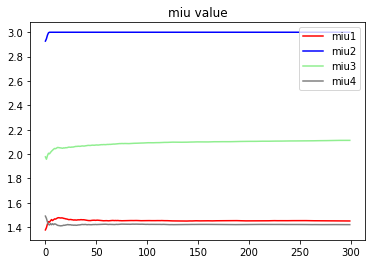

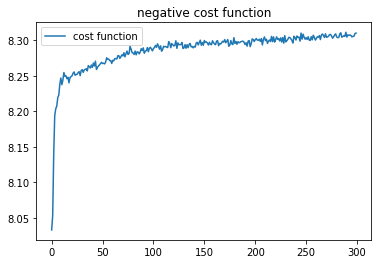

Final values  theta & cost [1.45099283 3.         2.1125851  1.42100489] -8.305196655489754


In [10]:
def main():
    
    miu0 = np.array([1.37761434, 2.92741548, 1.97681173, 1.49089615])
    
    m  = 300 # iterations
    ep = 0.01
    eta = 0.1
    power = 0.3
    n = 100
    
    miu = stochasticapproximation(miu0,m,ep,eta,power,n)
    
if __name__ == '__main__':
    main()

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %


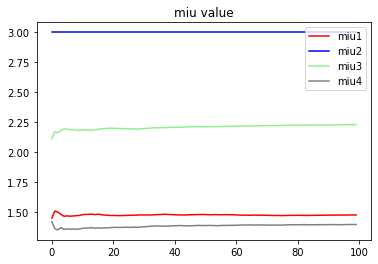

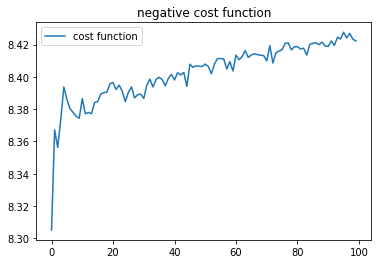

Final values  theta & cost [1.47703791 3.         2.23110622 1.39767455] -8.422301775203234


In [14]:
def main():
    
    miu0 = np.array([1.45099283, 3.         ,2.1125851,  1.42100489])
    
    m  = 100 # iterations
    ep = 0.01
    eta = 0.1
    power = 0.3
    n = 100
    
    miu = stochasticapproximation(miu0,m,ep,eta,power,n)
    
if __name__ == '__main__':
    main()

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %


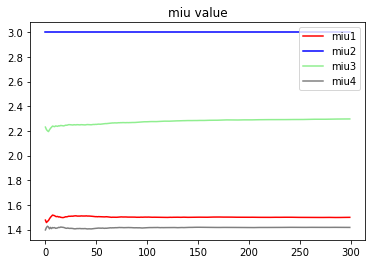

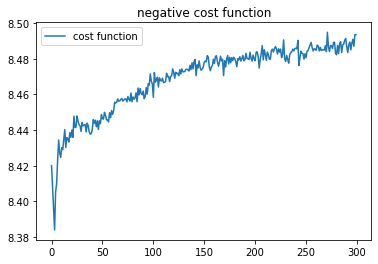

Final values  theta & cost [1.49961282 3.         2.29720476 1.41795699] -8.483809870785274


In [18]:
def main():
    
    miu0 = np.array([1.47703791, 3.        , 2.23110622, 1.39767455])
    
    m  = 300 # iterations
    ep = 0.01
    eta = 0.1
    power = 0.3
    n = 100
    
    miu = stochasticapproximation(miu0,m,ep,eta,power,n)
    
if __name__ == '__main__':
    main()

In [26]:
def stochasticapproximation_1(miu0, m,ep, eta, power, n):
    
    miu = np.zeros((4,m))
    Delta = np.zeros(4)
    cf = np.zeros(m)
     
    miu[:,0] = miu0
    for i in range(m-1):
        if i % (m//20)==0:
            print(i*100//m, "%")
        cf[i]= cost_function(miu[:,i], n)
        
        # sample Delta vector
        a1 = np.array([-1, 1])
        Delta = np.random.choice(a=a1, size=4, replace=True, p=[0.5, 0.5])
          
        # adjust stepsize
           
        eta_step= eta/((i+1)**power) 
        
        # evaluate SPSA proxy for gradient
        
        cost_plus = cost_function(miu[:,i]+eta_step*Delta, n)
        cost_minus = cost_function(miu[:,i]-eta_step*Delta, n)
        
        # SA update and truncation
        
        for j in range(4):
            miu[j, i+1] = miu[j, i] - (ep/(i+1)**0.5)*(cost_plus - cost_minus)/(eta_step*Delta[j]) 
            miu[j, i+1] = min(max(miu[j, i+1], 0.025), 3)
        
    cf[m-1]= cost_function(miu[:,m-1], n)
    
    # ouptu: print results
    
    plt.plot(np.arange(m),miu[0,:], color='red', label='miu1')
    plt.plot(np.arange(m),miu[1,:], color='blue', label='miu2')
    plt.plot(np.arange(m),miu[2,:], color='lightgreen', label='miu3')
    plt.plot(np.arange(m),miu[3,:], color='gray', label='miu4')
    plt.legend() 
    plt.title('miu value')
    plt.show()

    plt.plot(np.arange(m),-cf)
    plt.title('negative cost function')
    plt.legend(['cost function']) 
    plt.show()


    print("Final values  theta & cost", miu[:,m-1], cost_function(miu[:,m-1], n))    
    
    return miu

0 %
20 %
40 %
60 %
80 %


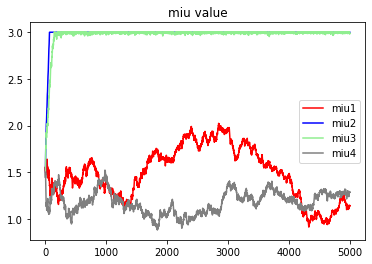

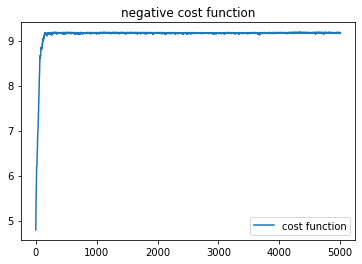

Final values  theta & cost [1.14201531 3.         2.98598819 1.28509953] -9.159180327203227


In [23]:
def main():
    
    miu0 = np.array([1.5,1.5,1.5,1.5])
    
    m  = 5000 # iterations
    ep = 0.01
    eta = 0.1
    power = 0.3
    n = 100
    
    miu = stochasticapproximation_1(miu0,m,ep,eta,power,n)
    
if __name__ == '__main__':
    main()

In [27]:
def main():
    
    miu0 = np.array([1.5,1.5,1.5,1.5])
    
    m  = 1000 # iterations
    ep = 0.01
    eta = 0.1
    power = 0.3
    n = 500
    
    miu = stochasticapproximation_1(miu0,m,ep,eta,power,n)
    
if __name__ == '__main__':
    main()

0 %


KeyboardInterrupt: 